<a href="https://colab.research.google.com/github/MosesIbe23/CSE_450_Private/blob/main/notebooks/starter_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [11]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

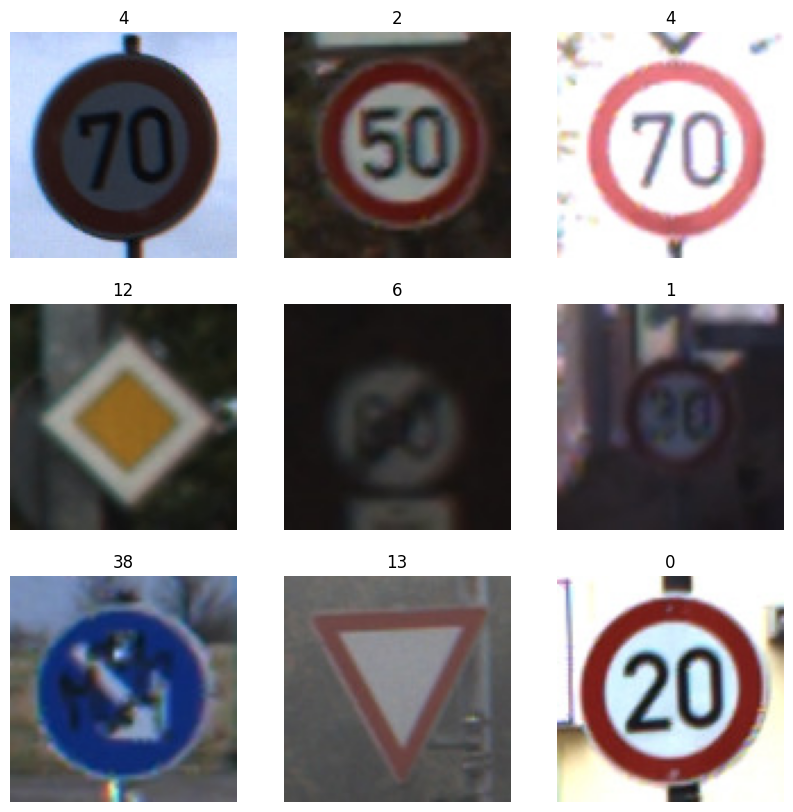

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [19]:
# Build a model...

#!ls /content/training
#!ls /content/mini_holdout

# images, labels = next(train_generator)
# print(images.shape)  # (32, 100, 100, 3)
# print(labels.shape)

# Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model's layers to retain pre-trained features
base_model.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(target_names), activation='softmax')  # len(target_names) is the number of classes
])

# Compile the model
model.compile(
    optimizer=RMSprop(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],# Vary brightness
    horizontal_flip=False,      # No flipping for non-symmetric signs
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(100, 100),
    subset="training",
    batch_size=32,
    class_mode='sparse',
    seed=45, shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=45)

# Train the model
import math

# Calculate steps per epoch
train_steps = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_steps,
    validation_steps=validation_steps,
    epochs=6
)

# Fine-tune the base model by unfreezing it
base_model.trainable = True
model.compile(
    optimizer=RMSprop(learning_rate=1e-5),  # Use a lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=18,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,987,627 (122.02 MB)

 Trainable params: 8,399,915 (32.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 161s 152ms/step - accuracy: 0.0520 - loss: 3.7216 - val_accuracy: 0.0898 - val_loss: 3.4642
Epoch 2/4
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/4


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


981/981 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - accuracy: 0.0717 - loss: 3.5245 - val_accuracy: 0.1093 - val_loss: 3.4191
Epoch 4/4
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 1/16


KeyboardInterrupt: 

In [16]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Get validation labels and predictions
val_labels = []
val_predictions = []

for i in range(len(validation_generator)):
    x, y = validation_generator[i]
    val_predictions.extend(np.argmax(model.predict(x), axis=1))
    val_labels.extend(y)

val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Class-wise classification report
report = classification_report(
    val_labels,
    val_predictions,
    target_names=target_names,
    digits=4
)
print("Classification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for idx, class_acc in enumerate(class_wise_accuracy):
    print(f"Accuracy for class {target_names[idx]}: {class_acc:.4f}")

# Evaluate specific performance expectations
# Stop Sign Index
stop_sign_index = target_names.index("STOP")
stop_sign_recall = recall_score(val_labels, val_predictions, labels=[stop_sign_index], average=None)[0]

overall_accuracy = np.mean(class_wise_accuracy)  # Overall mean accuracy

print("\nPerformance Metrics:")
print(f"Recall for STOP sign: {stop_sign_recall:.4f}")
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Performance thresholds
stop_sign_recall_threshold = 1.0
overall_accuracy_threshold = 0.95

if stop_sign_recall >= stop_sign_recall_threshold:
    print("✅ STOP sign recall meets the threshold.")
else:
    print("❌ STOP sign recall does NOT meet the threshold.")

if overall_accuracy >= overall_accuracy_threshold:
    print("✅ Overall accuracy meets the threshold.")
else:
    print("❌ Overall accuracy does NOT meet the threshold.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

In [17]:
# Identify underperforming classes
for idx, class_acc in enumerate(class_wise_accuracy):
    if class_acc < 0.85:  # Example threshold
        print(f"Class '{target_names[idx]}' needs improvement (Accuracy: {class_acc:.4f})")

Class 'Left_Curve_Ahead' needs improvement (Accuracy: 0.8095)
Class 'Right_Curve_Ahead' needs improvement (Accuracy: 0.7639)
Class 'Traffic_Light_Ahead' needs improvement (Accuracy: 0.8333)
Class 'Uncontrolled_Crossroad' needs improvement (Accuracy: 0.8000)
Class 'End_Previous_Limitation' needs improvement (Accuracy: 0.7500)
Class 'Straight_Or_Right_Mandatory' needs improvement (Accuracy: 0.7821)
Class 'End_Overtaking_Prohibition_Trucks' needs improvement (Accuracy: 0.7292)


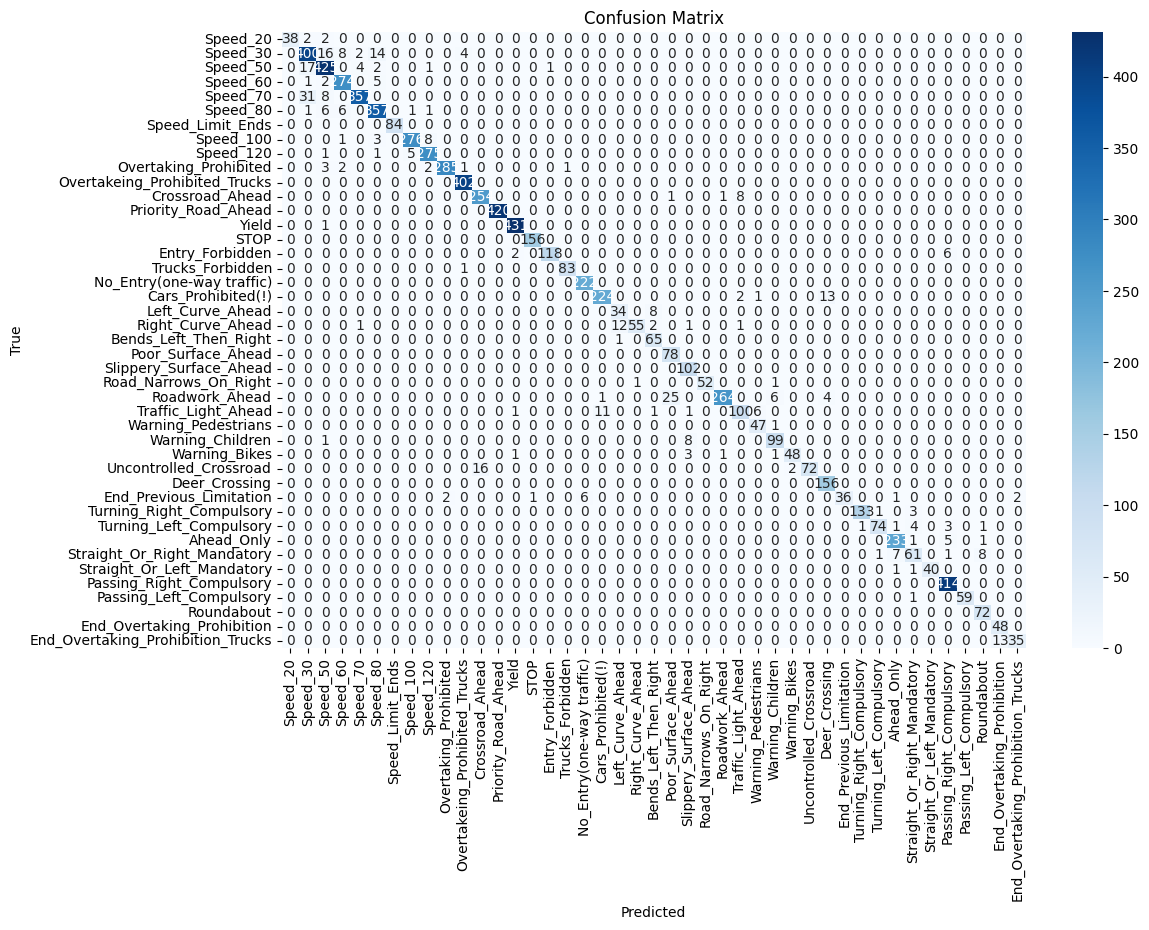

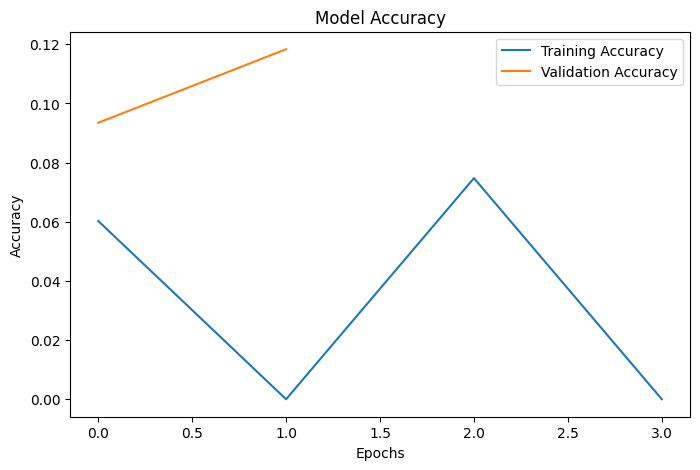

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```